# Natural scene detection
All code is taken from [this article](https://www.pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/)

In [1]:
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import cv2
from PIL import Image
from IPython.display import display, IFrame
import matplotlib.pyplot as plt

## Read and display image

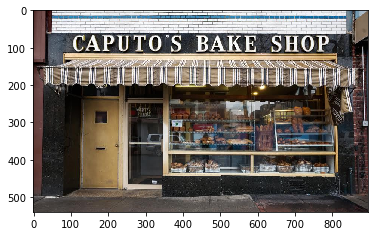

In [2]:
im_path = 'images/example_04.jpg'

# load the input image and grab the image dimensions
im = cv2.imread(im_path)
plt.imshow(
    # matplotlib needs RGB colour format
    cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
)
plt.show()

---
## 1. Pre-processing

In [3]:
orig = im.copy()  # we will draw outputs on this later
orig_h, orig_w, _ = im.shape
print(orig_w, orig_h)

896 540


### Resize images
EAST requires input images to be square, with side lengths in multiples of 32

In [4]:
# set the new width and height and then determine the ratio in change
# for both the width and height
new_w, new_h = 320, 320
w_ratio = orig_w / float(new_w)
h_ratio = orig_h / float(new_h)

In [5]:
print(h_ratio, w_ratio)

1.6875 2.8


320 320


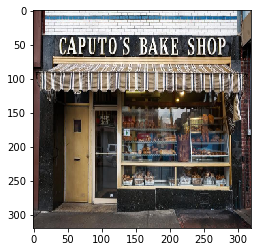

In [6]:
# resize the image and grab the new image dimensions
im = cv2.resize(im, (new_w, new_h))
h, w, _ = im.shape
print(h, w)
plt.imshow(
    # matplotlib needs RGB colour format
    cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
)
plt.show()

---
## 2. Detect text regions in image

Download the EAST model from [here](https://www.dropbox.com/s/r2ingd0l3zt8hxs/frozen_east_text_detection.tar.gz)

**Related content:**
  - Detecting machine-readable zones in passport images ([PyImageSearch tutorial](https://www.pyimagesearch.com/2015/11/30/detecting-machine-readable-zones-in-passport-images/))
  - OpenCV Text Detection ([PyImageSearch tutorial](https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/))
  - EAST: An Efficient and Accurate Scene Text Detector ([arXiv paper](https://arxiv.org/abs/1704.03155))

### Mean subtraction
R=103.93, G=116.77, and B=123.68 are mean values for the ImageNet training set (I am guessing EAST was trained on data that had been transformed in this way).

In [7]:
# construct a blob from the image
blob = cv2.dnn.blobFromImage(
    im,
    scalefactor=1.0,
    size=(w, h),
    mean=(123.68, 116.78, 103.94),
    swapRB=True,
    crop=False
)

### Predict text regions
EAST model segments image into 80 x 80 boxes and predicts likelihood that each box contains text (I think).

In [8]:
# load the pre-trained EAST text detector
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"
]

In [9]:
# perform a forward pass of the model to obtain the two output layer sets
net.setInput(blob)
scores, geometry = net.forward(layerNames)

In [10]:
scores

array([[[[5.4678873e-07, 5.2196643e-08, 1.5670153e-08, ...,
          7.4309150e-07, 4.1689080e-07, 4.4803027e-08],
         [1.9878457e-06, 3.4983472e-07, 2.5550023e-07, ...,
          4.8558800e-06, 4.4227170e-07, 5.0136187e-11],
         [1.7049275e-06, 6.5338021e-08, 2.1140661e-08, ...,
          3.9947790e-05, 4.3148995e-07, 1.8011559e-11],
         ...,
         [3.2755590e-06, 1.3832603e-06, 2.3695923e-06, ...,
          1.0382324e-07, 7.4642532e-09, 1.9191291e-06],
         [1.6454683e-06, 1.5193053e-06, 1.3380310e-06, ...,
          1.4001408e-07, 3.1639766e-07, 3.9999641e-06],
         [6.6553724e-07, 8.3417632e-08, 6.6470577e-08, ...,
          2.9649564e-06, 1.8410817e-06, 6.3886762e-07]]]], dtype=float32)

In [11]:
scores.shape

(1, 1, 80, 80)

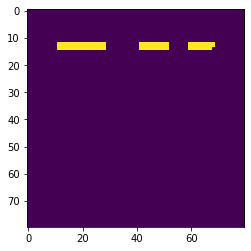

In [12]:
plt.imshow(scores.reshape(80,80))
plt.show()

In [13]:
geometry.shape

(1, 5, 80, 80)

### Retrieve text region bounding box coordinates + confidence scores

In [14]:
def decode_predictions(scores, geometry, min_confidence=.5):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    num_rows, num_cols = scores.shape[-2:]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, num_rows):
        # extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scores_data = scores[0, 0, y]
        x_data_0 = geometry[0, 0, y]
        x_data_1 = geometry[0, 1, y]
        x_data_2 = geometry[0, 2, y]
        x_data_3 = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, num_cols):
            # if our score does not have sufficient probability,
            # ignore it
            if scores_data[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offset_x, offset_y) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = angles_data[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height
            # of the bounding box
            h = x_data_0[x] + x_data_2[x]
            w = x_data_1[x] + x_data_3[x]

            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            end_x = int(offset_x + (cos * x_data_1[x]) + (sin * x_data_2[x]))
            end_y = int(offset_y - (sin * x_data_1[x]) + (cos * x_data_2[x]))
            start_x = int(end_x - w)
            start_y = int(end_y - h)

            # add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((start_x, start_y, end_x, end_y))
            confidences.append(scores_data[x])

    # return a tuple of the bounding boxes and associated confidences
    print(f'Found {len(rects)} text regions with confidence > {min_confidence}')
    return rects, confidences

In [15]:
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
rects, confidences = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)
print(f'{len(boxes)} remaining after applying non-maxima suppression')

Found 116 text regions with confidence > 0.5
3 remaining after applying non-maxima suppression


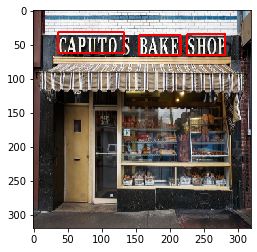

In [16]:
for box in boxes:
    cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)
    
plt.imshow(
    # matplotlib needs RGB colour format
    cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
)
plt.show()

## 3. Extract text from regions

In [21]:
padding = .05

# initialize the list of results
results = []

# loop over the bounding boxes
for (start_x, start_y, end_x, end_y) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    start_x = int(start_x * w_ratio)
    start_y = int(start_y * h_ratio)
    end_x = int(end_x * w_ratio)
    end_y = int(end_y * h_ratio)

    # in order to obtain a better OCR of the text we can potentially
    # apply a bit of padding surrounding the bounding box -- here we
    # are computing the deltas in both the x and y directions
    dX = int((end_x - start_x) * padding)
    dY = int((end_y - start_y) * padding)

    # apply padding to each side of the bounding box, respectively
    start_x = max(0, start_x - dX)
    start_y = max(0, start_y - dY)
    end_x = min(orig_w, end_x + (dX * 2))
    end_y = min(orig_h, end_y + (dY * 2))

    # extract the actual padded ROI
    roi = orig[start_y:end_y, start_x:end_x]

    # in order to apply Tesseract v4 to OCR text we must supply
    # (1) a language, (2) an OEM flag of 4, indicating that the we
    # wish to use the LSTM neural net model for OCR, and finally
    # (3) an OEM value, in this case, 7 which implies that we are
    # treating the ROI as a single line of text
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)

    # add the bounding box coordinates and OCR'd text to the list
    # of results
    results.append(((start_x, start_y, end_x, end_y), text))

# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])

In [22]:
results

[((87, 52, 398, 108), "CAPUTO'S"),
 ((625, 57, 803, 113), 'SHOP'),
 ((426, 58, 620, 113), 'BAKE')]

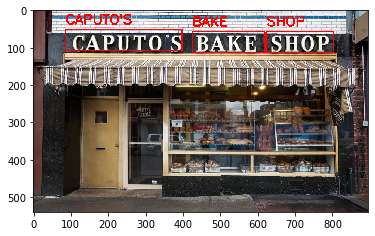

In [27]:
output = orig.copy()

# loop over the results
for ((start_x, start_y, end_x, end_y), text) in results:

    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV, then draw the text and a bounding box surrounding
    # the text region of the input image
    text = ''.join([c if ord(c) < 128 else '' for c in text]).strip()
    cv2.rectangle(output, (start_x, start_y), (end_x, end_y),
        (0, 0, 255), 2)
    cv2.putText(output, text, (start_x, start_y - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

plt.imshow(
    # matplotlib needs RGB colour format
    cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
)
plt.show()